<a href="https://colab.research.google.com/github/hollimey/capstone-application/blob/main/OceanWeatherApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get User Location Input

In [ ]:
# get user location input (U.S. only)

user_location = input("Please enter a U.S. city name to get weather information: ")

Please enter a U.S. city name to get weather information: seattle


#### Convert to Coords

In [ ]:
# use geocoding library to convert city name into lat and lon coordinates

# import libraries
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

geolocator = Nominatim(user_agent="weather_app")

try:
    location = geolocator.geocode(user_location)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        print(f"Latitude: {latitude}, Longitude: {longitude}")
    else:
        print(f"Location '{user_location}' not found.")
        latitude = None
        longitude = None
except (GeocoderTimedOut, GeocoderUnavailable) as e:
    print(f"Geocoding service error: {e}")
    latitude = None
    longitude = None

Latitude: 47.6038321, Longitude: -122.330062


### NOAA API Weather Data

In [ ]:
import requests

# fetch weather data from API
def fetch_weather_data(latitude, longitude):
    point_url = f"https://api.weather.gov/points/{latitude},{longitude}"
    try:
        response = requests.get(point_url)
        response.raise_for_status()  # raise an HTTPError for bad responses
        point_data = response.json()

        forecast_url = point_data['properties']['forecast']
        hourly_forecast_url = point_data['properties']['forecastHourly']
        gridpoints_forecast_url = f"https://api.weather.gov/gridpoints/{point_data['properties']['gridId']}/{point_data['properties']['gridX']},{point_data['properties']['gridY']}/forecast"


        # fetch forecast data
        forecast_response = requests.get(forecast_url)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()

        # fetch hourly forecast data
        hourly_forecast_response = requests.get(hourly_forecast_url)
        hourly_forecast_response.raise_for_status()
        hourly_forecast_data = hourly_forecast_response.json()

        # fetch gridpoints forecast data
        gridpoints_forecast_response = requests.get(gridpoints_forecast_url)
        gridpoints_forecast_response.raise_for_status()
        gridpoints_forecast_data = gridpoints_forecast_response.json()

        # returns a dictionary containing point, forecast, gridpoints forecast and hourly forecast data, or None if an error occurs
        return {
            "point_data": point_data,
            "forecast": forecast_data,
            "hourly_forecast": hourly_forecast_data,
            "gridpoints_forecast": gridpoints_forecast_data
        }

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None


# check if lat and lon are available; call fetch_weather_data function if so
weather_data_result = None
if latitude is not None and longitude is not None:
    weather_data_result = fetch_weather_data(latitude, longitude)
    if weather_data_result:
        print("Weather data fetched successfully.")
    else:
        print("Failed to fetch weather data.")
else:
    print("Cannot fetch weather data due to geocoding failure.")


# determine the state for which to fetch alerts
state_code = None
if weather_data_result and 'point_data' in weather_data_result and \
   'properties' in weather_data_result['point_data'] and \
   'relativeLocation' in weather_data_result['point_data']['properties'] and \
   'properties' in weather_data_result['point_data']['properties']['relativeLocation'] and \
   'state' in weather_data_result['point_data']['properties']['relativeLocation']['properties']:
    state_code = weather_data_result['point_data']['properties']['relativeLocation']['properties']['state']
    print(f"Determined state for alerts: {state_code}")
else:
    print("Could not determine state for fetching alerts.")


# fetch and parse alerts if state_code is available
parsed_alerts = [] # initialize parsed_alerts to an empty list
if state_code:
    # construct the URL for fetching active weather alerts
    alerts_url = f"https://api.weather.gov/alerts/active?area={state_code}"
    print(f"Fetching alerts from: {alerts_url}")

    # make an HTTP GET request to the alerts URL
    try:
        alerts_response = requests.get(alerts_url)

        # check if the response status code indicates success
        if alerts_response.status_code == 200:
            # parse the JSON response
            weather_alerts_data = alerts_response.json()
            print("Weather alerts data fetched successfully.")

            # parse the JSON response from the alerts API
            if weather_alerts_data and 'features' in weather_alerts_data:
                for feature in weather_alerts_data['features']:
                    if 'properties' in feature:
                        properties = feature['properties']
                        alert_info = {
                            'event': properties.get('event'),
                            'headline': properties.get('headline'),
                            'description': properties.get('description'),
                            'effective': properties.get('effective'),
                            'expires': properties.get('expires')
                        }
                        parsed_alerts.append(alert_info)

            print(f"Parsed {len(parsed_alerts)} active alerts.")

        else:
            print(f"Error fetching weather alerts: Status code {alerts_response.status_code}")
            weather_alerts_data = None

    except requests.exceptions.RequestException as e:
        print(f"Error during weather alerts request: {e}")
        weather_alerts_data = None
else:
    print("State code not available. Cannot fetch weather alerts.")
    weather_alerts_data = None

Weather data fetched successfully.
Determined state for alerts: WA
Fetching alerts from: https://api.weather.gov/alerts/active?area=WA
Weather alerts data fetched successfully.
Parsed 0 active alerts.


#### View Fetched Data

In [ ]:
import requests
import json # Import the json library
from datetime import datetime


# explore the structure of the fetched NOAA weather data
if weather_data_result:
    # Save weather_data_result and parsed_alerts to a JSON file
    weather_output_data = {
        "weather_data": weather_data_result,
        "weather_alerts": parsed_alerts
    }
    output_filename = "noaa_weather_data.json"
    try:
        with open(output_filename, 'w') as f:
            json.dump(weather_output_data, f, indent=4)
        print(f"Weather data and alerts saved to {output_filename}")
    except Exception as e:
        print(f"\nError saving weather data and alerts to JSON: {e}")

else:
    print("Weather data has not been fetched yet.\n")


# Removed the printing of all fetched data and the message for no active weather alerts.

Weather data and alerts saved to noaa_weather_data.json


### EPA API Air Quality Data

In [ ]:
# fetch AQ data from EPA API

import requests

# NOTE: replace later with a secure method for handling API keys
AIRNOW_API_KEY = "17C7530F-6ED9-40D5-8DA3-A8328CB8F1B0"
airnow_url = f"https://www.airnowapi.org/aq/observation/latLong/current/?format=application/json&latitude={latitude}&longitude={longitude}&distance=25&API_KEY={AIRNOW_API_KEY}"

try:
    response = requests.get(airnow_url)
    response.raise_for_status()  # raise an HTTPError for bad responses
    aq_data = response.json()
    print("Air quality data fetched successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching air quality data: {e}")
    aq_data = None

Air quality data fetched successfully.


#### View Fetched Data

In [ ]:
# print a preview of the fetched AQ EPA data

import json # Import the json library

if aq_data:
    # Specify the filename for the JSON file
    aq_output_filename = "epa_air_quality_data.json"

    try:
        # Write the air quality data to a JSON file
        with open(aq_output_filename, 'w') as f:
            json.dump(aq_data, f, indent=4)
        print(f"Air quality data saved to {aq_output_filename}")
    except Exception as e:
        print(f"Error saving air quality data to JSON: {e}")

else:
    print("Air quality data not available to save.")

Air quality data saved to epa_air_quality_data.json


### Weather Visualizations

#### Hourly Graphs

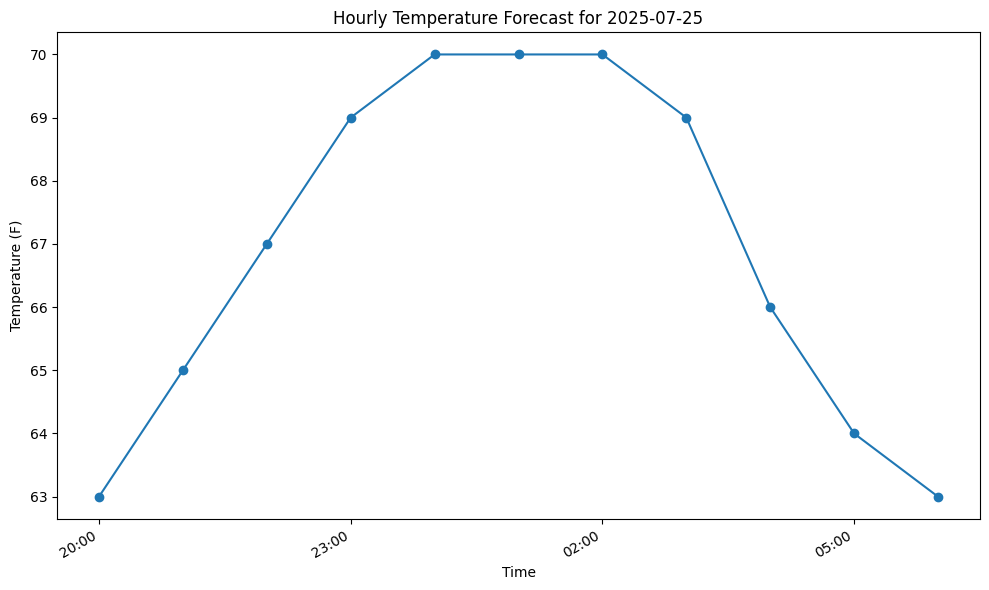

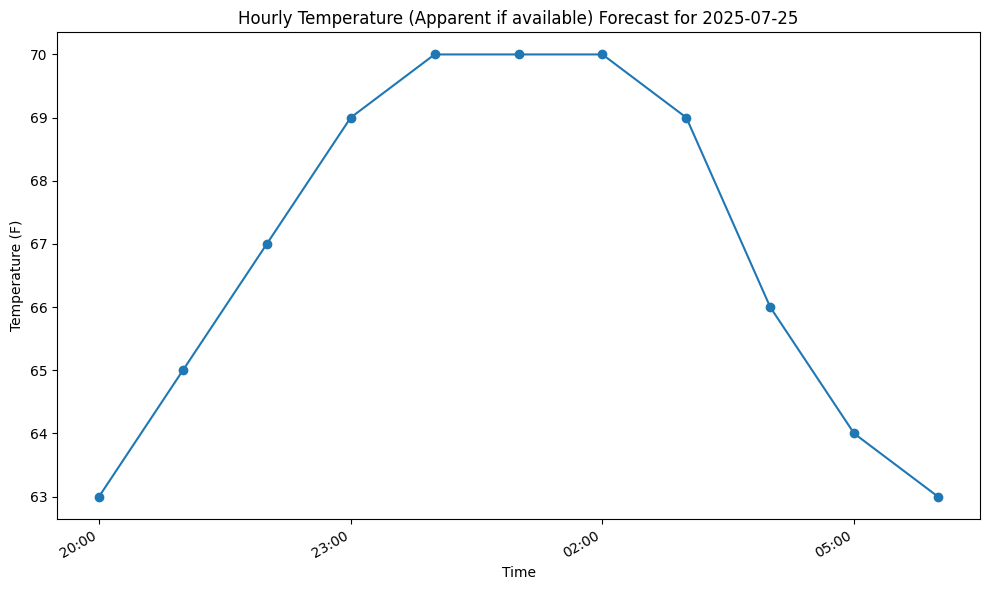

Cloud Cover data not available for visualization for the current date.


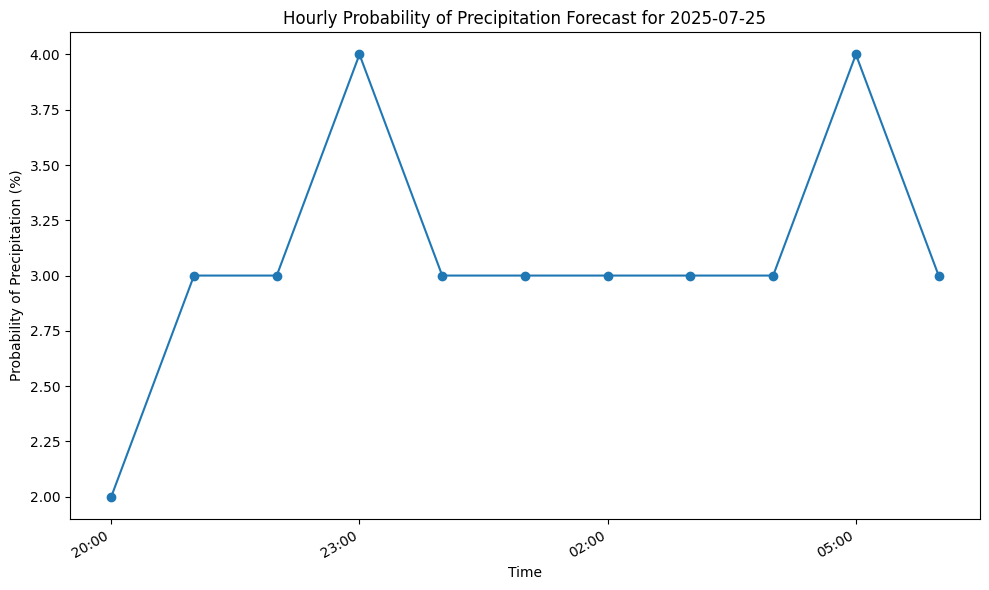

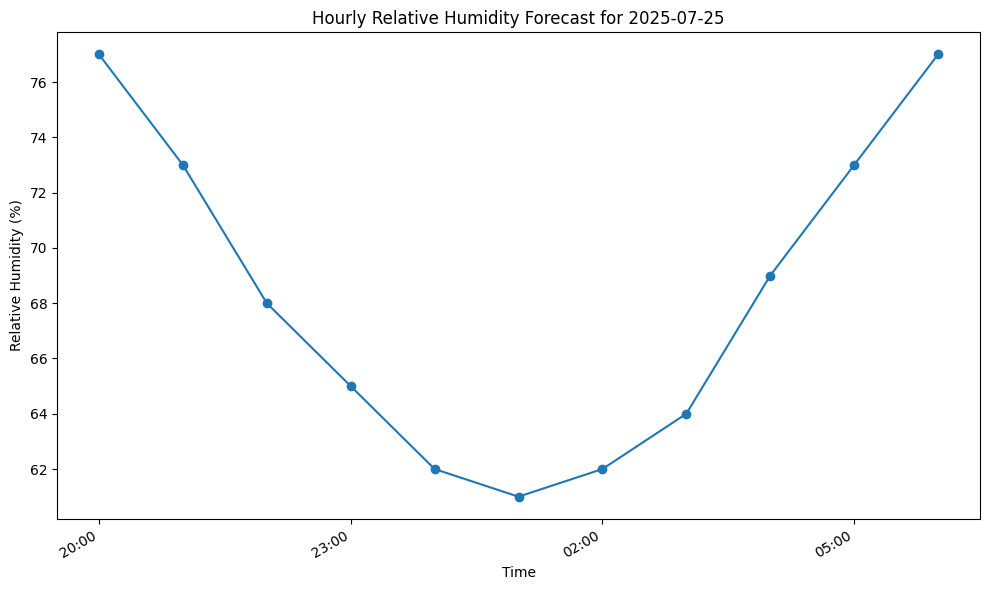

Visibility data not available for visualization for the current date.


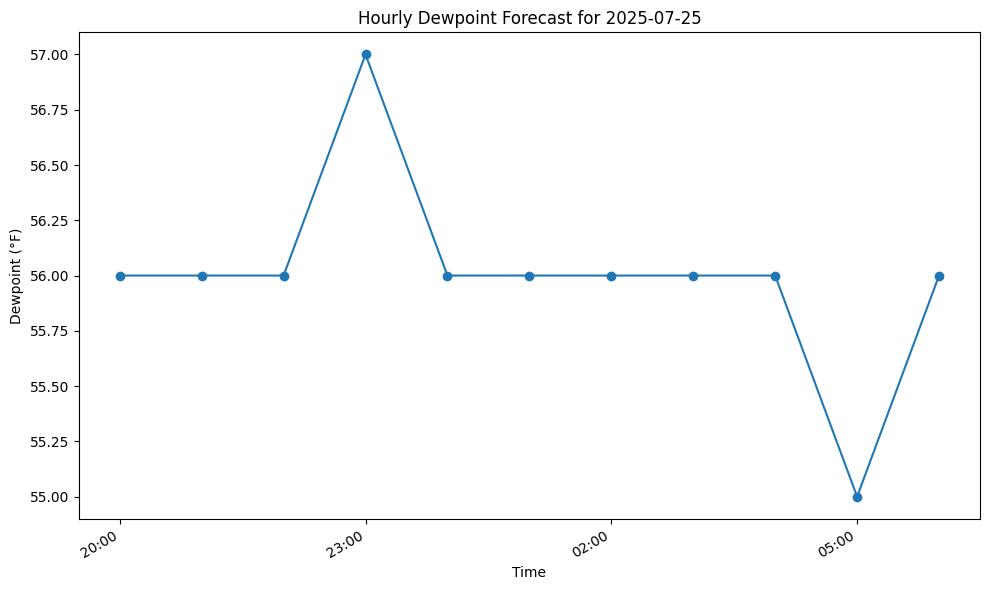

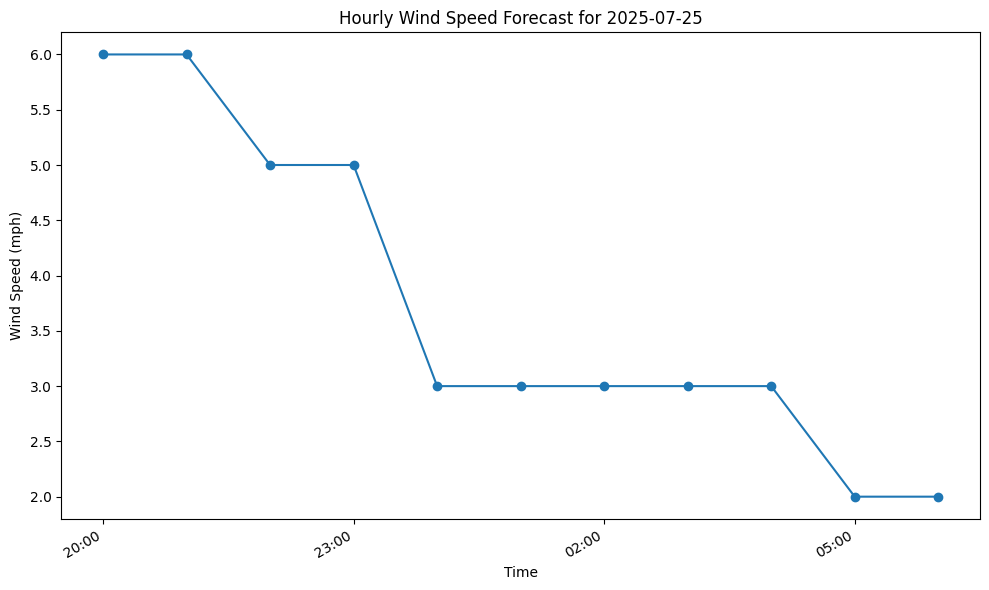

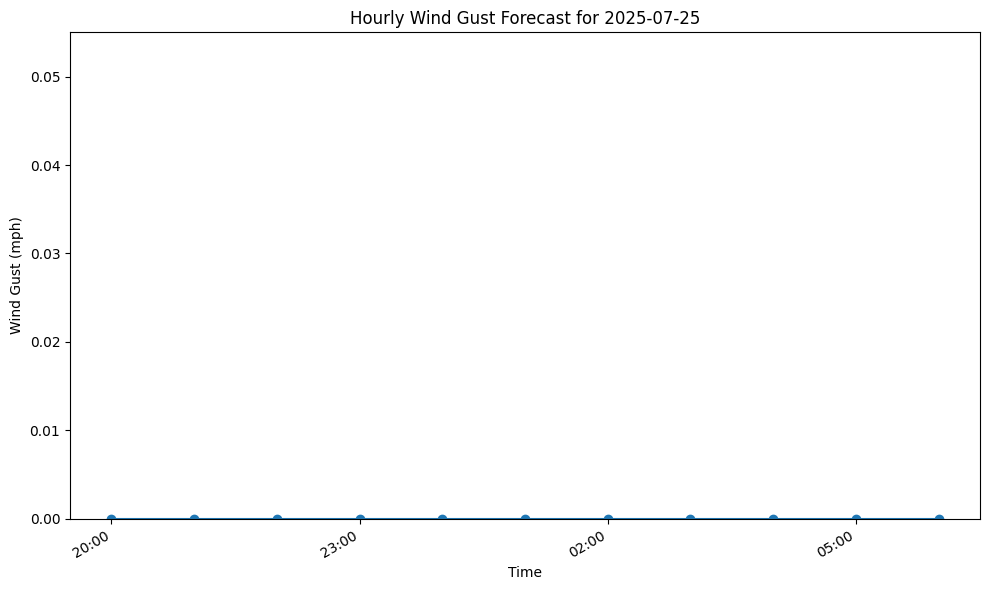

Sky Cover data not available for visualization for the current date.
Heat Index data not available for visualization for the current date.
Snowfall data not available or no snowfall predicted for the current date.
Ice accumulation data not available or no ice accumulation predicted for the current date.


In [ ]:
# hourly temperature forecast line graph -------------------------------------

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from datetime import date

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        temperatures = [period['temperature'] for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, temperatures, marker='o')
        plt.xlabel("Time")
        plt.ylabel(f"Temperature ({hourly_periods_today[0]['temperatureUnit']})")
        plt.title(f"Hourly Temperature Forecast for {today.strftime('%Y-%m-%d')}")

        # format the x-axis to show time with appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        # format tick locations
        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)

        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly apparent temperature forecast line graph ----------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]

        # use apparent temperature if available, otherwise use temperature
        temperatures = []
        for period in hourly_periods_today:
            apparent_temp = period.get('apparentTemperature', {}).get('value')
            if apparent_temp is not None:
                temperatures.append(apparent_temp)
            else:
                temperatures.append(period.get('temperature'))

        # determine the unit
        temp_unit = hourly_periods_today[0].get('temperatureUnit', '')

        plt.figure(figsize=(10, 6))
        plt.plot(times, temperatures, marker='o')
        plt.xlabel("Time")
        plt.ylabel(f"Temperature ({temp_unit})") # label reflects whats plotted
        plt.title(f"Hourly Temperature (Apparent if available) Forecast for {today.strftime('%Y-%m-%d')}")

        # format the x-axis to show time with appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        # format tick locations
        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)

        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly cloud cover forecast line graph -------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract cloud cover - need to handle potential None values
        cloud_cover_values = [period.get('cloudCover', {}).get('value') for period in hourly_periods_today]

        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(cloud_cover_values) if val is not None]
        cloud_cover_values_filtered = [val for val in cloud_cover_values if val is not None]


        if not cloud_cover_values_filtered:
             print("Cloud Cover data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, cloud_cover_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel("Cloud Cover (%)")
            plt.title(f"Hourly Cloud Cover Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly precipitation forecast probability line graph -----------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract probability of precipitation
        precipitation_probs = [period.get('probabilityOfPrecipitation', {}).get('value', 0) for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, precipitation_probs, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Probability of Precipitation (%)")
        plt.title(f"Hourly Probability of Precipitation Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly humidity forecast line graph ----------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # Extract relative humidity
        humidity_values = [period.get('relativeHumidity', {}).get('value', 0) for period in hourly_periods_today]

        plt.figure(figsize=(10, 6))
        plt.plot(times, humidity_values, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Relative Humidity (%)")
        plt.title(f"Hourly Relative Humidity Forecast for {today.strftime('%Y-%m-%d')}")

        # format the x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly visibility forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract visibility
        visibility_values = []
        visibility_unit = '' # initialize unit
        for period in hourly_periods_today:
            visibility_data = period.get('visibility', {})
            value = visibility_data.get('value')
            if value is not None:
                visibility_values.append(value)
                # capture the unit from the first available data point
                if not visibility_unit and visibility_data.get('unitCode'):
                    visibility_unit = visibility_data.get('unitCode')
            else:
                visibility_values.append(None) # append if data is missing

        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(visibility_values) if val is not None]
        visibility_values_filtered = [val for val in visibility_values if val is not None]


        if not visibility_values_filtered:
             print("Visibility data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, visibility_values_filtered, marker='o')
            plt.xlabel("Time")
            # set ylabel based on the captured unit
            ylabel = "Visibility"
            if visibility_unit:
                 ylabel += f" ({visibility_unit})"

            plt.ylabel(ylabel)
            plt.title(f"Hourly Visibility Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)

            plt.gcf().autofmt_xdate() # auto-format for labels overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly dewpoint forecast line graph ----------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract dewpoint - need to handle potential None values
        dewpoint_values = [period.get('dewpoint', {}).get('value') for period in hourly_periods_today]

        # convert dewpoint from C to F if temperature unit is F
        if hourly_periods_today and hourly_periods_today[0].get('temperatureUnit') == 'F':
             dewpoint_values = [(d * 9/5) + 32 if d is not None else None for d in dewpoint_values]
             dewpoint_unit = 'F'
        elif hourly_periods_today and hourly_periods_today[0].get('dewpoint') and hourly_periods_today[0]['dewpoint'].get('unitCode'):
             dewpoint_unit = hourly_periods_today[0]['dewpoint'].get('unitCode')
        else:
             dewpoint_unit = ''


        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(dewpoint_values) if val is not None]
        dewpoint_values_filtered = [val for val in dewpoint_values if val is not None]


        if not dewpoint_values_filtered:
             print("Dewpoint data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, dewpoint_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Dewpoint (°{dewpoint_unit})")
            plt.title(f"Hourly Dewpoint Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly wind speed forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract wind speed
        wind_speeds = []
        for period in hourly_periods_today:
            # for cases when windSpeed is 0
            speed_str = period.get('windSpeed', '0 mph').split(' ')[0]
            try:
                wind_speeds.append(int(speed_str))
            except ValueError:
                # for cases when windSpeed is a range; takes the first number
                 try:
                     wind_speeds.append(int(speed_str.split(' to ')[0]))
                 except ValueError:
                     wind_speeds.append(0) # default to 0 if parsing fails

        plt.figure(figsize=(10, 6))
        plt.plot(times, wind_speeds, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Wind Speed (mph)")
        plt.title(f"Hourly Wind Speed Forecast for {today.strftime('%Y-%m-%d')}")

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly wind gust forecast line graph ---------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract windGust
        wind_gusts = []
        for period in hourly_periods_today:
            gust_str = period.get('windGust')
            if gust_str: # check if windGust exists and is not None/empty
                try:
                    # for when windGust is a number or a range
                    if ' to ' in gust_str:
                        wind_gusts.append(int(gust_str.split(' to ')[0]))
                    else:
                        # assume unit is separated by space
                        wind_gusts.append(int(gust_str.split(' ')[0]))
                except (ValueError, IndexError):
                    wind_gusts.append(0) # default to 0 if parsing fails
            else:
                wind_gusts.append(0) # append 0 if windGust is missing


        plt.figure(figsize=(10, 6))
        plt.plot(times, wind_gusts, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Wind Gust (mph)") # changed label to Wind Gust
        plt.title(f"Hourly Wind Gust Forecast for {today.strftime('%Y-%m-%d')}") # changed title

        # set the y-axis limit to start at 0
        plt.ylim(bottom=0)

        # format x-axis to show only time and set appropriate intervals
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        import numpy as np
        hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
        ax.xaxis.set_major_locator(hours)


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly sky cover forecast line graph --------------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract skyCover - need to handle potential None values
        sky_cover_values = [period.get('skyCover', {}).get('value') for period in hourly_periods_today]

        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(sky_cover_values) if val is not None]
        sky_cover_values_filtered = [val for val in sky_cover_values if val is not None]

        if not sky_cover_values_filtered:
             print("Sky Cover data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, sky_cover_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel("Sky Cover (%)")
            plt.title(f"Hourly Sky Cover Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly heat / UV index forecast line graph ---------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract heat index - need to handle potential None values
        heat_index_values = [period.get('heatIndex', {}).get('value') for period in hourly_periods_today]

        # determine the unit if available
        heat_index_unit = ''
        if hourly_periods_today and hourly_periods_today[0].get('heatIndex') and hourly_periods_today[0]['heatIndex'].get('unitCode'):
             heat_index_unit = hourly_periods_today[0]['heatIndex'].get('unitCode')


        # remove None values for plotting
        times_filtered = [times[i] for i, val in enumerate(heat_index_values) if val is not None]
        heat_index_values_filtered = [val for val in heat_index_values if val is not None]


        if not heat_index_values_filtered:
             print("Heat Index data not available for visualization for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times_filtered, heat_index_values_filtered, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Heat Index (°{heat_index_unit})")
            plt.title(f"Hourly Heat Index Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly snowfall amount forecast line graph ---------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract snowfallAmount
        snowfall_values = []
        snowfall_unit = ''
        for period in hourly_periods_today:
            snowfall_data = period.get('snowfallAmount', {})
            value = snowfall_data.get('value')
            if value is not None:
                snowfall_values.append(value)
                # capture the unit from the first available data point
                if not snowfall_unit and snowfall_data.get('unitCode'):
                    snowfall_unit = snowfall_data.get('unitCode')
            else:
                snowfall_values.append(0) # append 0 if data is missing


        if not any(snowfall_values): # check for any snowfall predictions
             print("Snowfall data not available or no snowfall predicted for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times, snowfall_values, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Snowfall Amount ({snowfall_unit})")
            plt.title(f"Hourly Snowfall Amount Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")



# hourly ice accumulation forecast line graph --------------------------------

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']

    # filter for the current date
    today = date.today()
    hourly_periods_today = [
        period for period in hourly_periods
        if datetime.fromisoformat(period['startTime']).date() == today
    ]

    if not hourly_periods_today:
        print("No hourly forecast data available for the current date.")
    else:
        times = [datetime.fromisoformat(period['startTime']) for period in hourly_periods_today]
        # extract iceAccumulation
        ice_accumulation_values = []
        ice_accumulation_unit = ''
        for period in hourly_periods_today:
            ice_data = period.get('iceAccumulation', {})
            value = ice_data.get('value')
            if value is not None:
                ice_accumulation_values.append(value)
                # capture the unit from the first available data point
                if not ice_accumulation_unit and ice_data.get('unitCode'):
                    ice_accumulation_unit = ice_data.get('unitCode')
            else:
                # append 0 if data is missing
                ice_accumulation_values.append(0)

        # check if there is any ice accumulation predicted
        if not any(ice_accumulation_values):
             print("Ice accumulation data not available or no ice accumulation predicted for the current date.")
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(times, ice_accumulation_values, marker='o')
            plt.xlabel("Time")
            plt.ylabel(f"Ice Accumulation ({ice_accumulation_unit})")
            plt.title(f"Hourly Ice Accumulation Forecast for {today.strftime('%Y-%m-%d')}")

            # format x-axis to show only time and set appropriate intervals
            ax = plt.gca()
            formatter = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_formatter(formatter)

            import numpy as np
            hours = mdates.HourLocator(interval=3)  # set a tick every 3 hours
            ax.xaxis.set_major_locator(hours)


            plt.gcf().autofmt_xdate() # format to prevent label overlapping

            plt.tight_layout()
            plt.show()
else:
    print("Hourly forecast data not available for visualization.")

#### Hourly Container +7-Day

In [ ]:
# hourly forecast container for 7-days

if weather_data_result and 'hourly_forecast' in weather_data_result:
    hourly_periods = weather_data_result['hourly_forecast']['properties']['periods']
    print("\n--- Hourly Forecast ---")
    for period in hourly_periods:
        print(f"\nTime: {datetime.fromisoformat(period['startTime']).strftime('%Y-%m-%d %H:%M')}")
        print(f"  Temperature: {period.get('temperature')}°{period.get('temperatureUnit', '')}")

        if period.get('windChill') and period['windChill'].get('value') is not None:
             print(f"  Wind Chill: {period['windChill']['value']}°{period['windChill'].get('unitCode', '')}")

        if period.get('heatIndex') and period['heatIndex'].get('value') is not None:
             print(f"  Heat Index: {period['heatIndex']['value']}°{period['heatIndex'].get('unitCode', '')}")
        print(f"  Wind Speed: {period.get('windSpeed', 'N/A')}")
        print(f"  Wind Direction: {period.get('windDirection', 'N/A')}")

        if period.get('cloudCover') and period['cloudCover'].get('value') is not None:
             print(f"  Cloud Cover: {period['cloudCover']['value']}%")

        if period.get('probabilityOfPrecipitation') and period['probabilityOfPrecipitation'].get('value') is not None:
             print(f"  Probability of Precipitation: {period['probabilityOfPrecipitation']['value']}%")

        if period.get('dewpoint') and period['dewpoint'].get('value') is not None:
             # convert dewpoint from C to F if temperature unit is F
             dewpoint_value = period['dewpoint']['value']
             dewpoint_unit = period['dewpoint'].get('unitCode', '')
             if period.get('temperatureUnit') == 'F' and dewpoint_unit == 'wmoUnit:degC':
                 dewpoint_value = (dewpoint_value * 9/5) + 32
                 dewpoint_unit = 'F' # update unit to F

             # if the original unit is already F (unlikely)
             elif period.get('temperatureUnit') == 'F' and dewpoint_unit == 'wmoUnit:degF':
                 dewpoint_unit = 'F'

             print(f"  Dewpoint: {dewpoint_value:.0f}°{dewpoint_unit}")


        if period.get('relativeHumidity') and period['relativeHumidity'].get('value') is not None:
             print(f"  Relative Humidity: {period['relativeHumidity']['value']}%")

        print(f"  Short Forecast: {period.get('shortForecast', 'N/A')}")

else:
    print("Hourly forecast data not available.")


--- Hourly Forecast ---

Time: 2025-07-25 13:00
  Temperature: 63°F
  Wind Speed: 6 mph
  Wind Direction: SSW
  Probability of Precipitation: 2%
  Dewpoint: 56°F
  Relative Humidity: 77%
  Short Forecast: Mostly Cloudy

Time: 2025-07-25 14:00
  Temperature: 65°F
  Wind Speed: 6 mph
  Wind Direction: WSW
  Probability of Precipitation: 3%
  Dewpoint: 56°F
  Relative Humidity: 73%
  Short Forecast: Mostly Cloudy

Time: 2025-07-25 15:00
  Temperature: 67°F
  Wind Speed: 5 mph
  Wind Direction: W
  Probability of Precipitation: 3%
  Dewpoint: 56°F
  Relative Humidity: 68%
  Short Forecast: Partly Sunny

Time: 2025-07-25 16:00
  Temperature: 69°F
  Wind Speed: 5 mph
  Wind Direction: WNW
  Probability of Precipitation: 4%
  Dewpoint: 57°F
  Relative Humidity: 65%
  Short Forecast: Partly Sunny

Time: 2025-07-25 17:00
  Temperature: 70°F
  Wind Speed: 3 mph
  Wind Direction: WNW
  Probability of Precipitation: 3%
  Dewpoint: 56°F
  Relative Humidity: 62%
  Short Forecast: Partly Sunny

Time

#### 7-Day Graphs

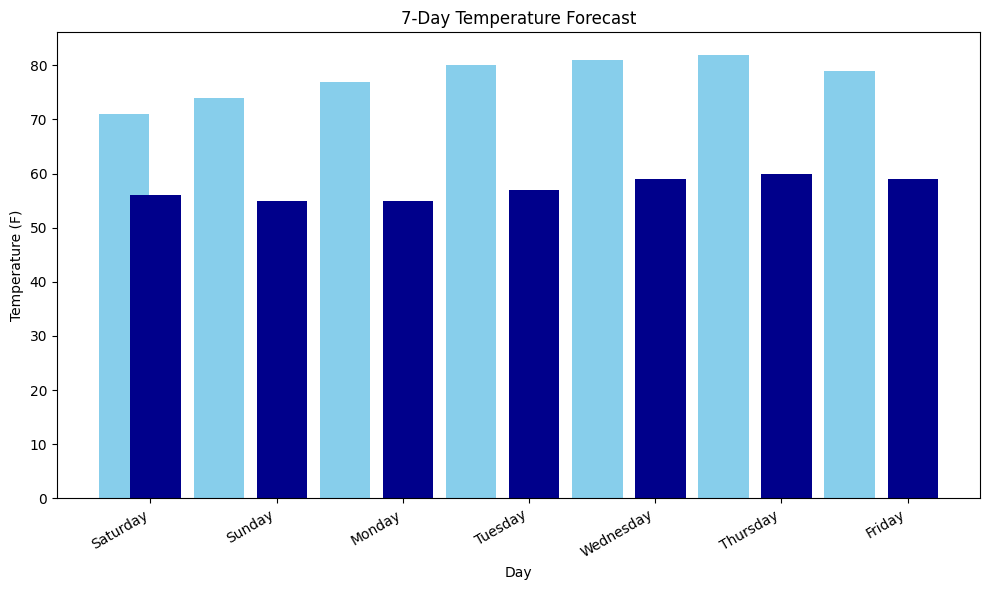

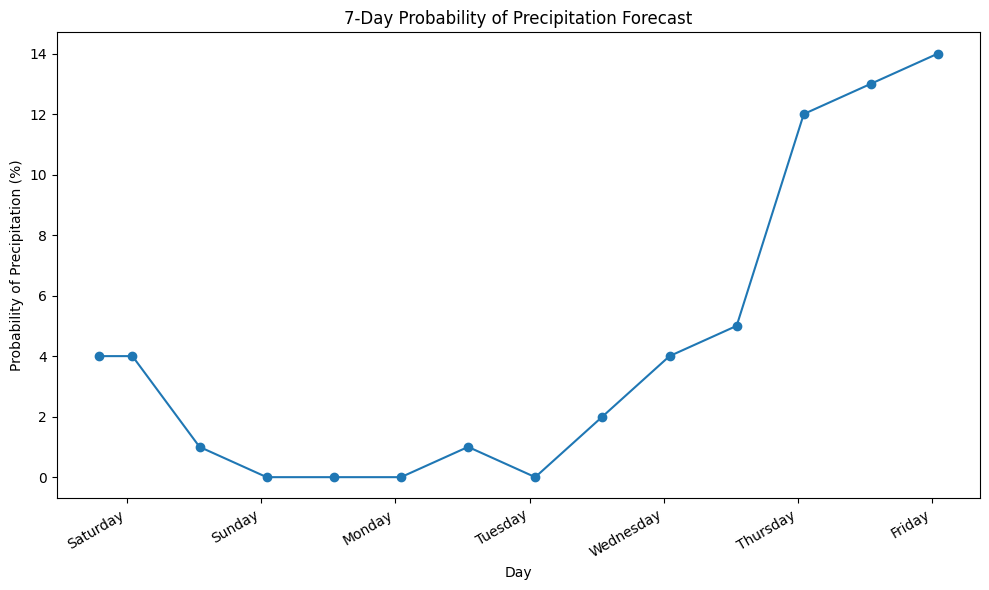

In [ ]:
# 7-day temperature bar graph ------------------------------------------------

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']

    if not forecast_periods:
        print("7-day forecast data not available for visualization.")
    else:
        # extract times, temperatures, and daytime status for each period
        times = [datetime.fromisoformat(period['startTime']) for period in forecast_periods]
        temperatures = [period['temperature'] for period in forecast_periods]
        is_daytime = [period['isDaytime'] for period in forecast_periods]

        # eetermine the unit
        temp_unit = forecast_periods[0].get('temperatureUnit', '')

        # define colors for day and night
        colors = ['skyblue' if day else 'darkblue' for day in is_daytime]

        plt.figure(figsize=(10, 6))
        # plot bars with different colors based on daytime status
        plt.bar(times, temperatures, width=0.4, color=colors)
        plt.xlabel("Day")
        plt.ylabel(f"Temperature ({temp_unit})")
        plt.title("7-Day Temperature Forecast")

        # format the x-axis to show days of the week
        ax = plt.gca()
        formatter = mdates.DateFormatter('%A')
        ax.xaxis.set_major_formatter(formatter)

        # set tick locations (one tick per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("7-day forecast data not available for visualization.")


# 7-day precipitation probability line graph ---------------------------------

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']

    if not forecast_periods:
        print("7-day forecast data not available for visualization.")
    else:
        # extract times and probability of precipitation for each period
        times = [datetime.fromisoformat(period['startTime']) for period in forecast_periods]
        # extract probability of precipitation, handling potential None values
        precipitation_probs = [period.get('probabilityOfPrecipitation', {}).get('value', 0) for period in forecast_periods]

        plt.figure(figsize=(10, 6))
        plt.plot(times, precipitation_probs, marker='o')
        plt.xlabel("Day")
        plt.ylabel("Probability of Precipitation (%)")
        plt.title("7-Day Probability of Precipitation Forecast")

        # format the x-axis to show days of the week
        ax = plt.gca()
        formatter = mdates.DateFormatter('%A')
        ax.xaxis.set_major_formatter(formatter)

        # set tick locations (one tick per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())


        plt.gcf().autofmt_xdate() # auto-format to prevent labels overlapping

        plt.tight_layout()
        plt.show()
else:
    print("7-day forecast data not available for visualization.")

#### 7-Day Container

In [ ]:
# 7-day forecast container

if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']
    print("--- 7-Day Forecast ---")
    for period in forecast_periods:
        print(f"\n{period['name']}:")
        print(f"  Temperature: {period.get('temperature')}°{period.get('temperatureUnit', '')}")
        print(f"  Conditions: {period.get('shortForecast', 'N/A')}")
        print(f"  Detailed Forecast: {period.get('detailedForecast', 'N/A')}")
        print(f"  Wind Speed: {period.get('windSpeed', 'N/A')}")
        print(f"  Wind Direction: {period.get('windDirection', 'N/A')}")

        # include probability of precipitation
        if period.get('probabilityOfPrecipitation') and period['probabilityOfPrecipitation'].get('value') is not None:
             print(f"  Probability of Precipitation: {period['probabilityOfPrecipitation']['value']}%")
else:
    print("Forecast data not available.")

--- 7-Day Forecast ---

This Afternoon:
  Temperature: 71°F
  Conditions: Mostly Cloudy
  Detailed Forecast: Mostly cloudy, with a high near 71. West wind around 6 mph.
  Wind Speed: 6 mph
  Wind Direction: W
  Probability of Precipitation: 4%

Tonight:
  Temperature: 56°F
  Conditions: Mostly Cloudy
  Detailed Forecast: Mostly cloudy. Low around 56, with temperatures rising to around 58 overnight. North northeast wind around 3 mph.
  Wind Speed: 3 mph
  Wind Direction: NNE
  Probability of Precipitation: 4%

Saturday:
  Temperature: 74°F
  Conditions: Mostly Cloudy
  Detailed Forecast: Mostly cloudy. High near 74, with temperatures falling to around 72 in the afternoon. South southwest wind around 5 mph.
  Wind Speed: 5 mph
  Wind Direction: SSW
  Probability of Precipitation: 1%

Saturday Night:
  Temperature: 55°F
  Conditions: Mostly Cloudy
  Detailed Forecast: Mostly cloudy, with a low around 55. North northwest wind around 3 mph.
  Wind Speed: 3 mph
  Wind Direction: NNW
  Probab

#### 7-Day Container +Alerts

In [ ]:
# 7-day container with alerts

from datetime import datetime, timezone

# integrate alerts within the daily forecast
if weather_data_result and 'forecast' in weather_data_result:
    forecast_periods = weather_data_result['forecast']['properties']['periods']
    print("\n--- 7-Day Forecast with Alerts ---")
    for period in forecast_periods:
        # convert period times to datetime objects (assuming ISO 8601 format)
        start_time = datetime.fromisoformat(period['startTime'])
        end_time = datetime.fromisoformat(period['endTime'])

        print(f"\n{period['name']}:")
        print(f"  Temperature: {period['temperature']}°{period['temperatureUnit']}")
        print(f"  Conditions: {period['shortForecast']}")

        # check for relevant active alerts within forecast period
        relevant_alerts = []
        if parsed_alerts:
            for alert in parsed_alerts:
                alert_effective = datetime.fromisoformat(alert.get('effective')) if alert.get('effective') else None
                alert_expires = datetime.fromisoformat(alert.get('expires')) if alert.get('expires') else None

                # check if alert times overlap with the forecast period
                if alert_effective and alert_expires:
                    # an alert is relevant if it starts before or during the period and ends after or during the period
                    if (alert_effective <= end_time and alert_expires >= start_time):
                         relevant_alerts.append(alert)
                # alert with no explicit end time
                elif alert_effective and not alert_expires:
                     if alert_effective <= end_time:
                          relevant_alerts.append(alert)
                # alert with no explicit start time (uncommon)
                elif not alert_effective and alert_expires:
                     if alert_expires >= start_time:
                           relevant_alerts.append(alert)
                # alert with no effective or expires time
                else:
                     pass


        if relevant_alerts:
            print("  Active Alerts:")
            for rel_alert in relevant_alerts:
                print(f"    - Event: {rel_alert.get('event', 'N/A')}")
                print(f"      Headline: {rel_alert.get('headline', 'N/A')}")

else:
    print("Forecast data not available.")


--- 7-Day Forecast with Alerts ---

This Afternoon:
  Temperature: 71°F
  Conditions: Mostly Cloudy

Tonight:
  Temperature: 56°F
  Conditions: Mostly Cloudy

Saturday:
  Temperature: 74°F
  Conditions: Mostly Cloudy

Saturday Night:
  Temperature: 55°F
  Conditions: Mostly Cloudy

Sunday:
  Temperature: 77°F
  Conditions: Mostly Sunny

Sunday Night:
  Temperature: 55°F
  Conditions: Mostly Clear

Monday:
  Temperature: 80°F
  Conditions: Sunny

Monday Night:
  Temperature: 57°F
  Conditions: Clear

Tuesday:
  Temperature: 81°F
  Conditions: Sunny

Tuesday Night:
  Temperature: 59°F
  Conditions: Mostly Clear

Wednesday:
  Temperature: 82°F
  Conditions: Mostly Sunny

Wednesday Night:
  Temperature: 60°F
  Conditions: Partly Cloudy

Thursday:
  Temperature: 79°F
  Conditions: Partly Sunny

Thursday Night:
  Temperature: 59°F
  Conditions: Partly Cloudy


#### Alerts Container


In [ ]:
# active weather alerts container

# iterate through the parsed alerts
if parsed_alerts:
    print("--- Active Weather Alerts ---")
    for alert in parsed_alerts:
        print(f"\nEvent: {alert.get('event', 'N/A')}")
        print(f"Headline: {alert.get('headline', 'N/A')}")
        print(f"Description: {alert.get('description', 'N/A')}")
        print(f"Effective: {alert.get('effective', 'N/A')}")
        print(f"Expires: {alert.get('expires', 'N/A')}")
        print("-" * 20) # separator for clarity
else:
    print("\nNo active weather alerts found for the specified location.")


No active weather alerts found for the specified location.


#### Air Quality Graph

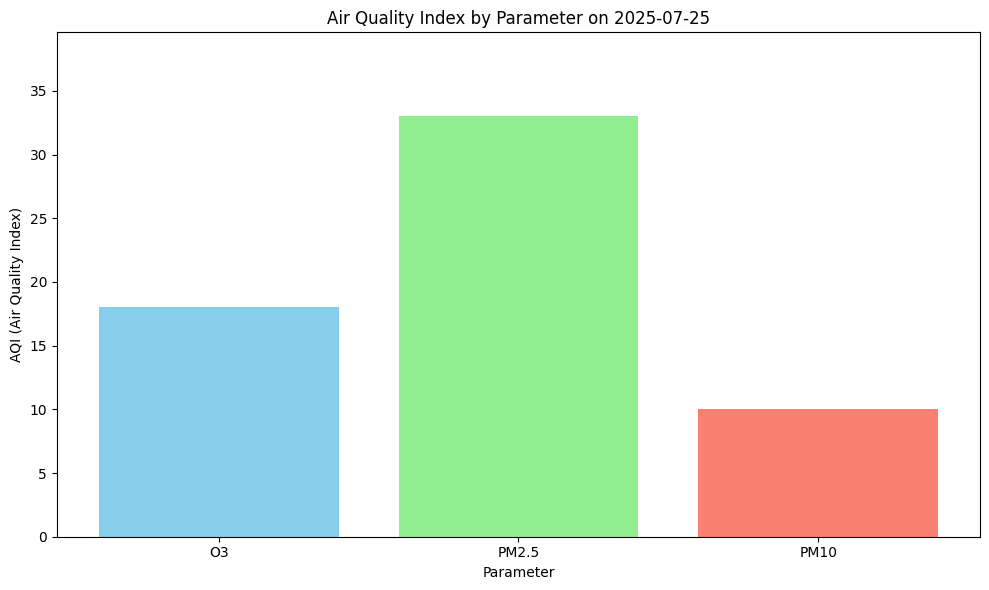

In [ ]:
# AQ (air quality) graph

import matplotlib.pyplot as plt
import pandas as pd

if aq_data:
    # convert list of dictionaries to a pandas DataFrame for easier handling
    aq_df = pd.DataFrame(aq_data)

    if not aq_df.empty:
      # extract date from the first entry (assuming all entries have same date)
      observation_date = aq_df['DateObserved'].iloc[0] if 'DateObserved' in aq_df.columns else "Unknown Date"

      # create a bar chart for AQI by Parameter
      plt.figure(figsize=(10, 6))
      plt.bar(aq_df['ParameterName'], aq_df['AQI'], color=['skyblue', 'lightgreen', 'salmon'])
      plt.xlabel("Parameter")
      plt.ylabel("AQI (Air Quality Index)")
      # add the date to the title
      plt.title(f"Air Quality Index by Parameter on {observation_date}")
      plt.ylim(0, aq_df['AQI'].max() * 1.2) # set y-axis limit a bit above the max AQI
      plt.tight_layout()
      plt.show()
    else:
      print("Air quality data is empty, cannot create visualizations.")
else:
  print("Air quality data not available for visualization.")

### NOAA Buoy Data

In [ ]:
# fetch and parse ocean data

import requests
import pandas as pd
from io import StringIO

# NOAA buoy data text file
noaa_url = "https://www.ndbc.noaa.gov/data/latest_obs/latest_obs.txt"
# listed variables: WDIR, WSPD, GST, WVHT, DPD, APD, MWD, PRES, PTDY, ATMP, WTMP, DEWP, VIS, TIDE

try:
  response = requests.get(noaa_url)
  response.raise_for_status()
  text_content = response.text

  # parse the text content into a pandas DataFrame
  # the data seems to be space-separated with a header row starting with '#'
  # we need to skip the comment lines at the beginning
  data_lines = text_content.strip().split('\n')
  # find the actual header row (usually starts with #)
  header_line_index = -1
  for i, line in enumerate(data_lines):
      if line.startswith('#'):
          header_line_index = i
          break

  if header_line_index != -1:
      # use StringIO to treat the string as a file and read with pandas
      # skip the initial comment lines and use the identified header
      noaa_df = pd.read_csv(StringIO('\n'.join(data_lines[header_line_index:])), sep='\s+', skiprows=[1]) # skip the units row
      print("Ocean data fetched and parsed successfully.")
  else:
      print("Could not find header line in NOAA buoy data.")
      noaa_df = None


except requests.exceptions.RequestException as e:
    print(f"Error fetching NOAA buoy data: {e}")
    noaa_df = None
except Exception as e:
    print(f"Error parsing NOAA buoy data: {e}")
    noaa_df = None

Ocean data fetched and parsed successfully.


#### View Fetched Data

In [ ]:
# print the first 10 lines to inspect the format
try:
  print('\n'.join(text_content.strip().split('\n')[:10]))

except requests.exceptions.RequestException as e:
  print(f"Error fetching NOAA ocean data: {e}")

#STN       LAT      LON  YYYY MM DD hh mm WDIR WSPD   GST WVHT  DPD APD MWD   PRES  PTDY  ATMP  WTMP  DEWP  VIS   TIDE
#text      deg      deg   yr mo day hr mn degT  m/s   m/s   m   sec sec degT   hPa   hPa  degC  degC  degC  nmi     ft
13001    12.000  -23.000 2025 07 25 19 00  17   5.1   6.2   MM  MM   MM  MM 1012.0    MM    MM    MM    MM   MM     MM
13002    21.000  -23.000 2025 07 25 19 00  MM    MM    MM   MM  MM   MM  MM     MM    MM  24.6    MM    MM   MM     MM
13008    15.000  -38.000 2025 07 25 19 00  65   8.7  10.3   MM  MM   MM  MM 1014.6    MM  25.8  26.4    MM   MM     MM
14048    -8.000   65.000 2025 07 25 19 00 162   8.3  10.6   MM  MM   MM  MM 1012.6    MM  27.2  27.8    MM   MM     MM
14049   -12.000   65.000 2025 07 25 19 00 126  10.7  13.2   MM  MM   MM  MM 1015.3    MM  24.1  26.0    MM   MM     MM
15001   -10.000  -10.000 2025 07 25 19 00 102   5.9   7.2   MM  MM   MM  MM 1017.0    MM  24.0  24.9    MM   MM     MM
15002     0.000  -10.000 2025 07 25 19 00 159   

#### Calculate Distance


In [ ]:
# calculate the distance between user location and each buoy station

# error message if no user location found
if latitude is None or longitude is None:
    print("User location could not be determined.")
    noaa_df = None # do not proceed if location is missing


from geopy.distance import geodesic

if noaa_df is not None:
    def calculate_distance(row):
        station_lat = pd.to_numeric(row['LAT'], errors='coerce')
        station_lon = pd.to_numeric(row['LON'], errors='coerce')

        if pd.isna(station_lat) or pd.isna(station_lon):
            return float('inf')

        try:
            user_coords = (latitude, longitude)
            station_coords = (station_lat, station_lon)
            return geodesic(user_coords, station_coords).miles
        except ValueError:
            return float('inf')

    noaa_df['Distance'] = noaa_df.apply(calculate_distance, axis=1)
    print("Distance to user location calculated for each station.")

Distance to user location calculated for each station.


#### Find Nearest Stations


In [ ]:
# find nearest stations and extract data

# define parameters for mapping to DataFrame column names:
# #STN, station ID
# LAT, LON (latitude, longitude)
# YR, MO, DD, hh, mm (timestamp)
# WDIR (Wind Direction)
# WSPD (Wind Speed)
# GST (Wind Gust)
# WVHT (Wave Height)
# DPD (Dominant Wave Period)
# APD (Average Wave Period)
# MWD (Mean Wave Direction)
# PRES (Atmospheric Pressure)
# PTDY (Pressure Tendency)
# ATMP (Air Temperature)
# WTMP (Water Temperature)
# DEWP (Dewpoint Temperature)
# VIS (Visibility)
# TIDE (Tide)

if noaa_df is not None:
    # sort the DataFrame by Distance
    nearest_stations_df = noaa_df.sort_values(by='Distance').reset_index(drop=True)

    # update to use correct column names based on the first row
    requested_parameters = {
        'WDIR': 'WDIR', 'WSPD': 'WSPD', 'GST': 'GST', 'WVHT': 'WVHT',
        'DPD': 'DPD', 'APD': 'APD', 'MWD': 'MWD', 'PRES': 'PRES',
        'PTDY': 'PTDY', 'ATMP': 'ATMP', 'WTMP': 'WTMP', 'DEWP': 'DEWP', 'VIS': 'VIS', 'TIDE': 'TIDE'
    }

    extracted_data = {} # initialize extracted_data here
    parameters_found = { # track which parameters are found
        param: False for param in requested_parameters.keys()
        }

    # iterate through stations, starting from the nearest
    for index, station in nearest_stations_df.iterrows():
        station_id = station['#STN'] # use '#STN' as the column name
        station_distance = station['Distance']
        print(f"\nChecking station {station_id} at {station_distance:.2f} miles...") # Re-added this print statement

        for param_name, col_name in requested_parameters.items():
            if not parameters_found[param_name]:
                param_value = station.get(col_name)

                if pd.notna(param_value) and str(param_value).strip().upper() != 'MM':
                    extracted_data[param_name] = param_value
                    parameters_found[param_name] = True
                    print(f"  Found {param_name}: {param_value}") # Kept this print statement
                else:
                    print(f"  {param_name} ({col_name}) missing (MM) or not available.") # Re-added this print statement

        if all(parameters_found.values()):
            print("\nAll requested parameters found.")
            break

    if not all(parameters_found.values()):
        missing_params = [param for param, found in parameters_found.items() if not found]
        print(f"\nCould not find data for the following parameters from available stations: {', '.join(missing_params)}")

else:
    print("Buoy data is not available to extract data.")


Checking station WPOW1 at 6.34 miles...
  Found WDIR: 170
  Found WSPD: 4.6
  Found GST: 4.6
  WVHT (WVHT) missing (MM) or not available.
  DPD (DPD) missing (MM) or not available.
  APD (APD) missing (MM) or not available.
  MWD (MWD) missing (MM) or not available.
  Found PRES: 1017.9
  Found PTDY: +0.0
  Found ATMP: 15.4
  WTMP (WTMP) missing (MM) or not available.
  Found DEWP: 15.4
  VIS (VIS) missing (MM) or not available.
  TIDE (TIDE) missing (MM) or not available.

Checking station BMTW1 at 14.13 miles...
  WVHT (WVHT) missing (MM) or not available.
  DPD (DPD) missing (MM) or not available.
  APD (APD) missing (MM) or not available.
  MWD (MWD) missing (MM) or not available.
  WTMP (WTMP) missing (MM) or not available.
  VIS (VIS) missing (MM) or not available.
  TIDE (TIDE) missing (MM) or not available.

Checking station TCMW1 at 23.02 miles...
  WVHT (WVHT) missing (MM) or not available.
  DPD (DPD) missing (MM) or not available.
  APD (APD) missing (MM) or not available.

#### Display Results


In [ ]:
# display the extracted ocean buoy data

print("The nearest NOAA buoy station(s) were identified and the requested \n ocean data was extracted, handling missing values by checking \n subsequent stations.")

print("\n--- Ocean Buoy Data from Nearest Station(s) ---")

if extracted_data:
    for param, value in extracted_data.items():
        print(f"{param}: {value}")
else:
    print("No buoy data could be extracted for the requested parameters.")

The nearest NOAA buoy station(s) were identified and the requested 
 ocean data was extracted, handling missing values by checking 
 subsequent stations.

--- Ocean Buoy Data from Nearest Station(s) ---
WDIR: 170
WSPD: 4.6
GST: 4.6
PRES: 1017.9
PTDY: +0.0
ATMP: 15.4
DEWP: 15.4
WTMP: 14.2
WVHT: 0.5
DPD: 5
APD: 3.7
MWD: 321
VIS: 5.9
TIDE: 2.11


### CO-OPS Sensor Data

In [ ]:
# source: https://opendap.co-ops.nos.noaa.gov/stations/index.jsp
# list of active National Water Level Observation Network (NWLON) stations

# ex station_id_num = 9063053

# water level: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=0&id={station_id_num}

# water temp: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=1&id={station_id_num}

# air temp: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=2&id={station_id_num}

# air pressure: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=3&id={station_id_num}

# winds: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=4&id={station_id_num}

# conductivity: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=5&id={station_id_num}

# humidity: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=6&id={station_id_num}

# air gap: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=7&id={station_id_num}

# visibility: https://opendap.co-ops.nos.noaa.gov/stations/data/getdata.jsp?p=8&id={station_id_num}


# API info: https://api.tidesandcurrents.noaa.gov/api/prod/#requestResponse


# Daily Maximum and Minimum Water Level Data (Hourly): https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={yyyymmdd}&end_date={yyyymmdd}&station={station_id_num}&product=daily_max_min&datum=MHHW&time_zone=gmt&units=metric&application=DataAPI_Sample&format=json


### Ocean Data

In [ ]:
# source: https://opendap.co-ops.nos.noaa.gov/axis/
# different SOAP (Simple Object Access Protocol) web services that contains sample requests, sample responses and sample Java Client code

#########

# source: https://opendap.co-ops.nos.noaa.gov/thredds/catalog/catalog.html
# Thematic Real-time Environmental Distributed Data Services (THREDDS) server allows users to access and download data sets



In [ ]:
# source: https://tidesandcurrents.noaa.gov/currents_info.html
# or https://tidesandcurrents.noaa.gov/noaacurrents/

# east coast currents predictions
https://tidesandcurrents.noaa.gov/noaacurrents/stations?g=444

# gulf coast currents predictions
https://tidesandcurrents.noaa.gov/noaacurrents/stations?g=445

# west coast currents predictions
https://tidesandcurrents.noaa.gov/noaacurrents/stations?g=447

# pacific currents predictions
https://tidesandcurrents.noaa.gov/noaacurrents/stations?g=446

# caribbean currents predictions
https://tidesandcurrents.noaa.gov/noaacurrents/stations?g=443



# source: https://tidesandcurrents.noaa.gov/tide_predictions.html

# west coast tide predictions
https://tidesandcurrents.noaa.gov/tide_predictions.html?gid=1743#listing

# east coast tide predictions
https://tidesandcurrents.noaa.gov/tide_predictions.html?gid=1746#listing

# gulf coast tide predictions
https://tidesandcurrents.noaa.gov/tide_predictions.html?gid=1748#listing

# pacific tide predictions
https://tidesandcurrents.noaa.gov/tide_predictions.html?gid=1749#listing

# caribbean island tide predictions
https://tidesandcurrents.noaa.gov/tide_predictions.html?gid=1750#listing

SyntaxError: invalid syntax (ipython-input-204-2390707279.py, line 5)

In [ ]:
import json

# Define your metadata as a Python dictionary
metadata = {
    "title": "Weather and Air Quality Data for Seattle",
    "author": "Your Name",
    "date_created": "2025-07-21",
    "description": "This data includes weather forecasts from the NOAA API and air quality data from the EPA AirNow API for the city of Seattle.",
    "data_sources": [
        {"name": "NOAA National Weather Service API", "url": "https://www.weather.gov/documentation/services-web-api"},
        {"name": "EPA AirNow API", "url": "https://www.airnowapi.org/"},
        {"name": "NOAA National Data Buoy Center (NDBC)", "url": "https://www.ndbc.noaa.gov/"},
        {"name": "NOAA Tides and Currents (CO-OPS)", "url": "https://tidesandcurrents.noaa.gov/"}
    ],
    "location": {
        # Access variables from the global scope
        "city": globals().get('user_location', 'N/A'),
        "latitude": globals().get('latitude', 'N/A'),
        "longitude": globals().get('longitude', 'N/A')
    },
    "weather_data_parameters": [
        "Temperature",
        "Wind Speed",
        "Wind Direction",
        "Probability of Precipitation",
        "Dewpoint",
        "Relative Humidity",
        "Short Forecast",
        "Detailed Forecast",
        "Cloud Cover",
        "Heat Index",
        "Snowfall Amount",
        "Ice Accumulation",
        "Visibility",
        "Wind Gust",
        "Wind Chill"
    ],
    "air_quality_parameters": [
        "Parameter Name",
        "AQI",
        "Category"
    ],
    "ocean_buoy_parameters": [
        "WDIR (Wind Direction)",
        "WSPD (Wind Speed)",
        "GST (Wind Gust)",
        "WVHT (Wave Height)",
        "DPD (Dominant Wave Period)",
        "APD (Average Wave Period)",
        "MWD (Mean Wave Direction)",
        "PRES (Atmospheric Pressure)",
        "PTDY (Pressure Tendency)",
        "ATMP (Air Temperature)",
        "WTMP (Water Temperature)",
        "DEWP (Dewpoint Temperature)",
        "VIS (Visibility)",
        "TIDE (Tide)"
    ]
}

# Specify the filename for your JSON file
json_filename = "metadata.json"

# Write the metadata to a JSON file
with open(json_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata successfully written to {json_filename}")